# Transpiling of `HHL` circuits

A minimal example.

In [1]:
import numpy as np
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, IBMQ
from qiskit.circuit import AncillaQubit
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [2]:
a = 1
b = -1/3
matrix = np.array([[a, b], [b, a]])
vector = np.array([1, 0])

In [3]:
naive_hhl_solution = HHL().solve(matrix, vector)

The commands above are used to create the circuit below:


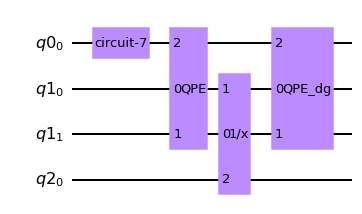

In [4]:
qc = naive_hhl_solution.state
qc.draw()


We'll run this circuit using a simulator and a 5-bits quantum computer.
In order to compare both effectively, we'll add a 5th, useless ancilla bit, so the simulator is as close as possible to the real implementation:

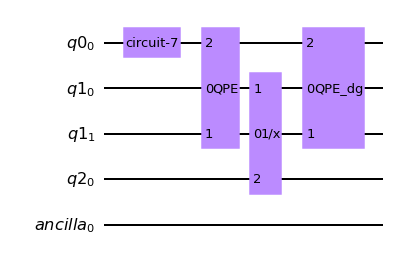

In [5]:
anc = QuantumRegister(1, 'ancilla')
qc.add_register(anc)
qc.draw()

## Transpile locally

We'll create a local equivalent of the remote machine:

In [6]:
# Physical characteristics of the remote machine Belem
basis_gates = ['id', 'rz', 'sx', 'x', 'cx']
coupling_map = [[0,1], [1,0], 
                [1,2], [2,1], 
                [1,3], [3,1], 
                [3,4], [4,3]]

In [7]:
backend_local = Aer.get_backend('aer_simulator')
circ_local = transpile(qc, backend_local, basis_gates=basis_gates, coupling_map=coupling_map)

And extract the operator:

In [8]:
op_local = Operator(circ_local)

## Transpile remotely

In [9]:
# Your personal and confidential token
ibmq_token = '' # <-- Insert your token here


IBMQ.enable_account(ibmq_token)
provider = IBMQ.get_provider(hub='ibm-q-qal', group='escience', project='qradio')

backend_remote = provider.get_backend('ibmq_belem')

circ_remote = transpile(circ_local, backend_remote, basis_gates=basis_gates, coupling_map=coupling_map)

And extract the operator:

In [10]:
op_remote = Operator(circ_remote)

## Problems

A first, ocular inspection of the transpiled circuits is enough to realize that both circuits are not identical.

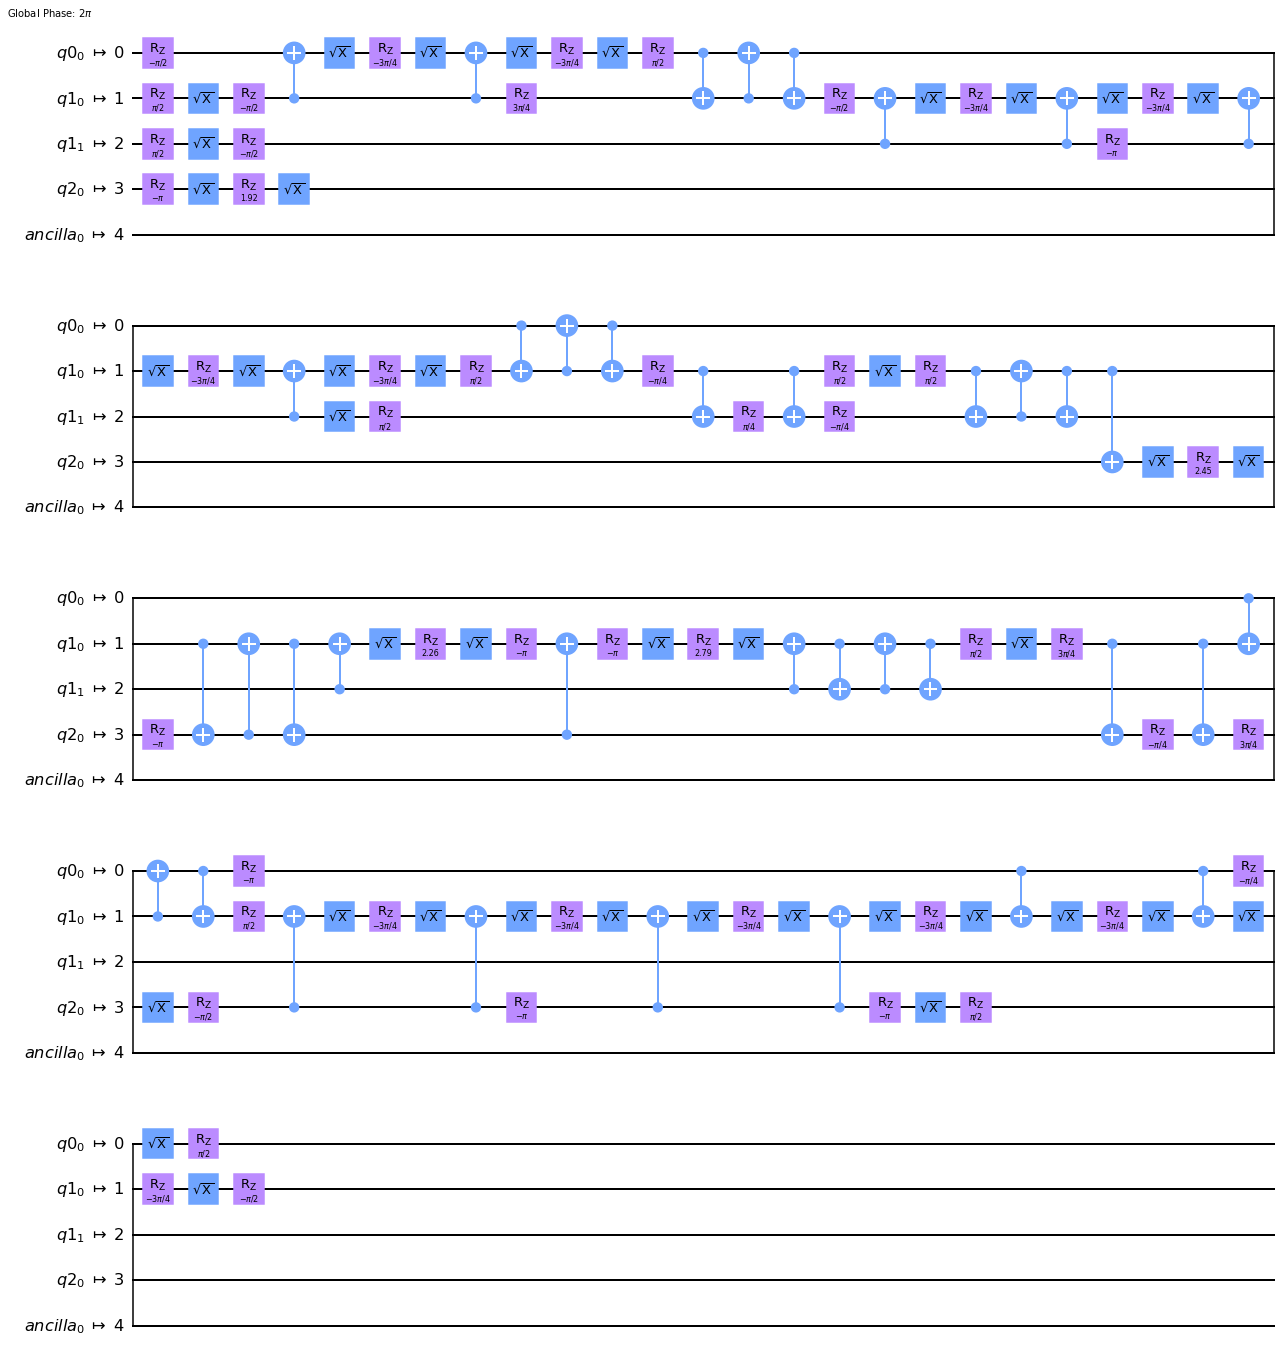

In [11]:
circ_local.draw()

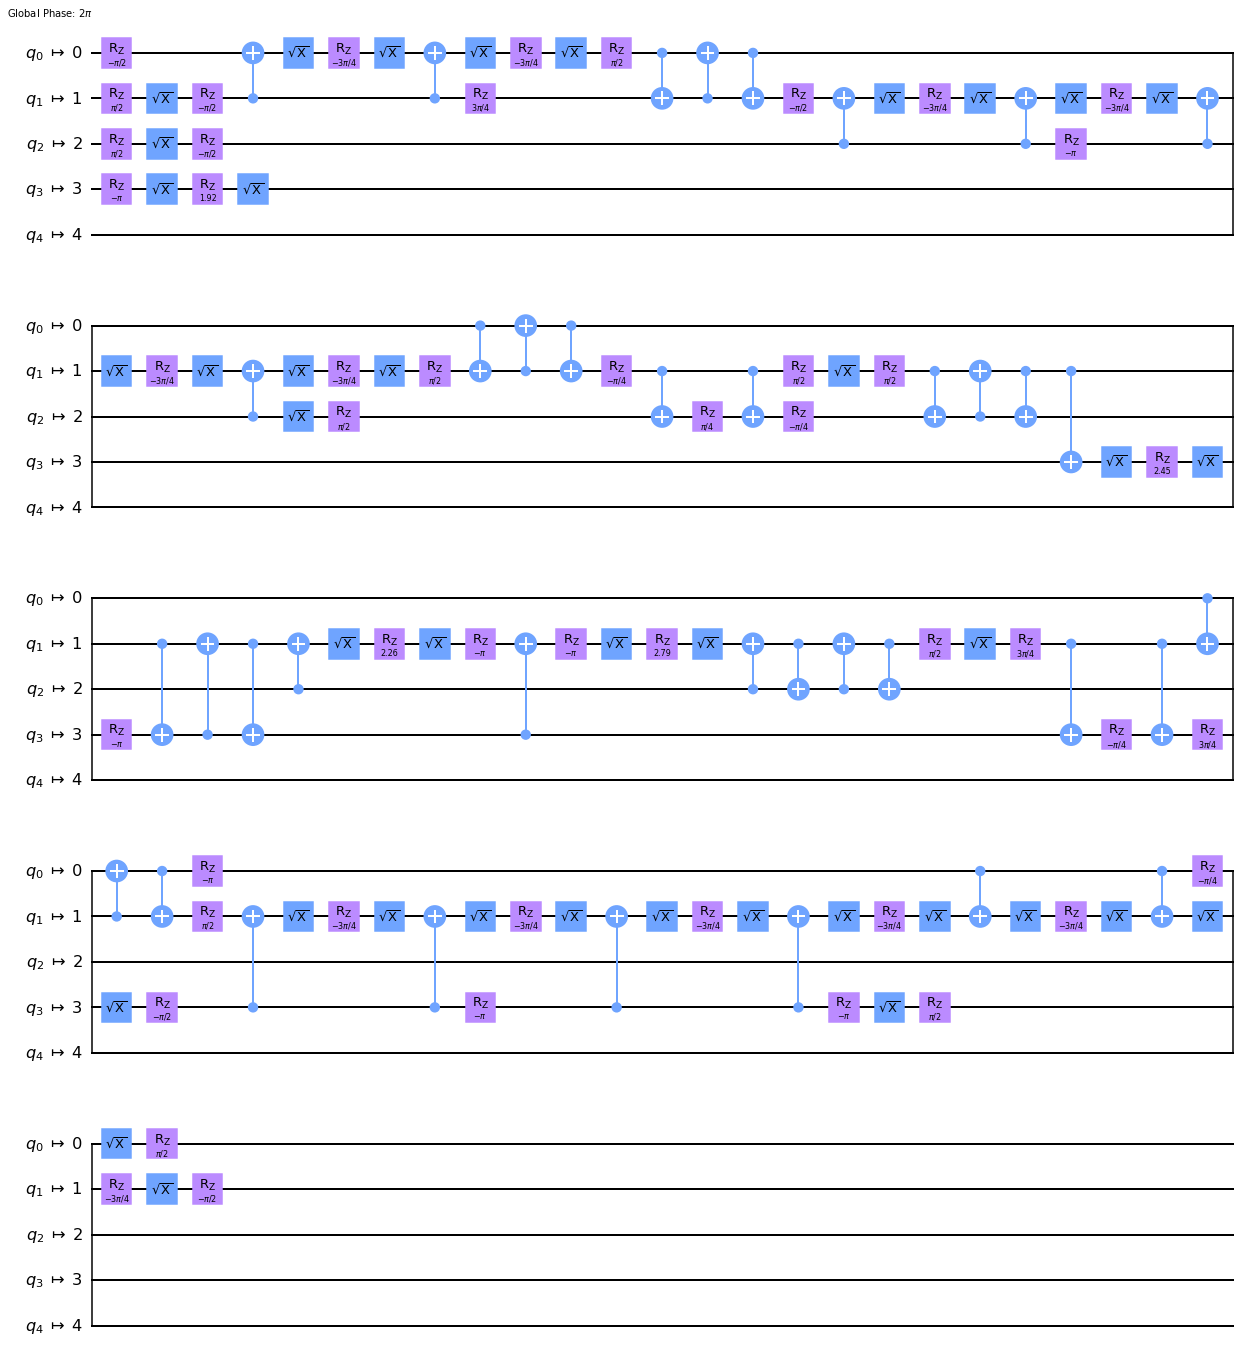

In [12]:
circ_remote.draw()

This is not very worrying, because different combinations of gates can generate equivalent circuits.

Nevertheless, if two circuits are equivalent, their operator matrices have to be identical.

In [13]:
op_local == op_remote

True

Now we can perform the measurements:

In [14]:
circ_local.measure_active()
circ_remote.measure_active()

## Perform the experiment

## Locally

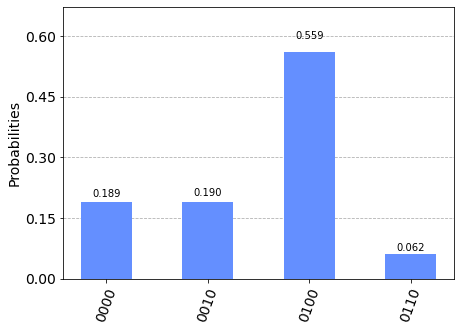

In [15]:
shots = 100000
result_local = backend_local.run(circ_local, shots=shots).result()
counts_local = result_local.get_counts()

plot_histogram(counts_local)

## Locally, with the remotely transpiled circuit

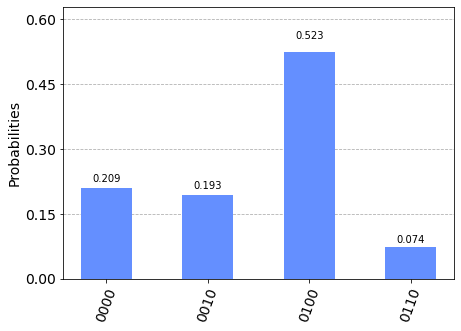

In [16]:
shots = 1024
result_remote = backend_local.run(circ_remote, shots=shots).result()
counts_remote = result_remote.get_counts()

plot_histogram(counts_remote)

## Remotely


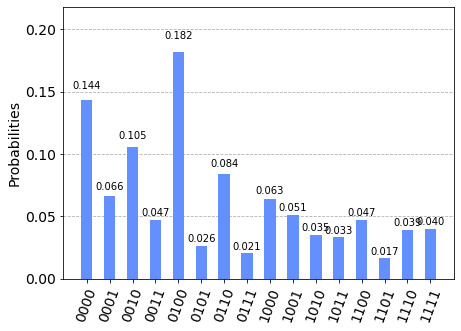

In [17]:
shots = 1024
result_remote = backend_remote.run(circ_remote, shots=shots).result()
counts_remote = result_remote.get_counts()

plot_histogram(counts_remote)